In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Question 13: This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly, )
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA ,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
Weekly = load_data('Weekly')

(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

We can see that there seems to be a relation between the Volumn and Year. 

In [4]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [5]:
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


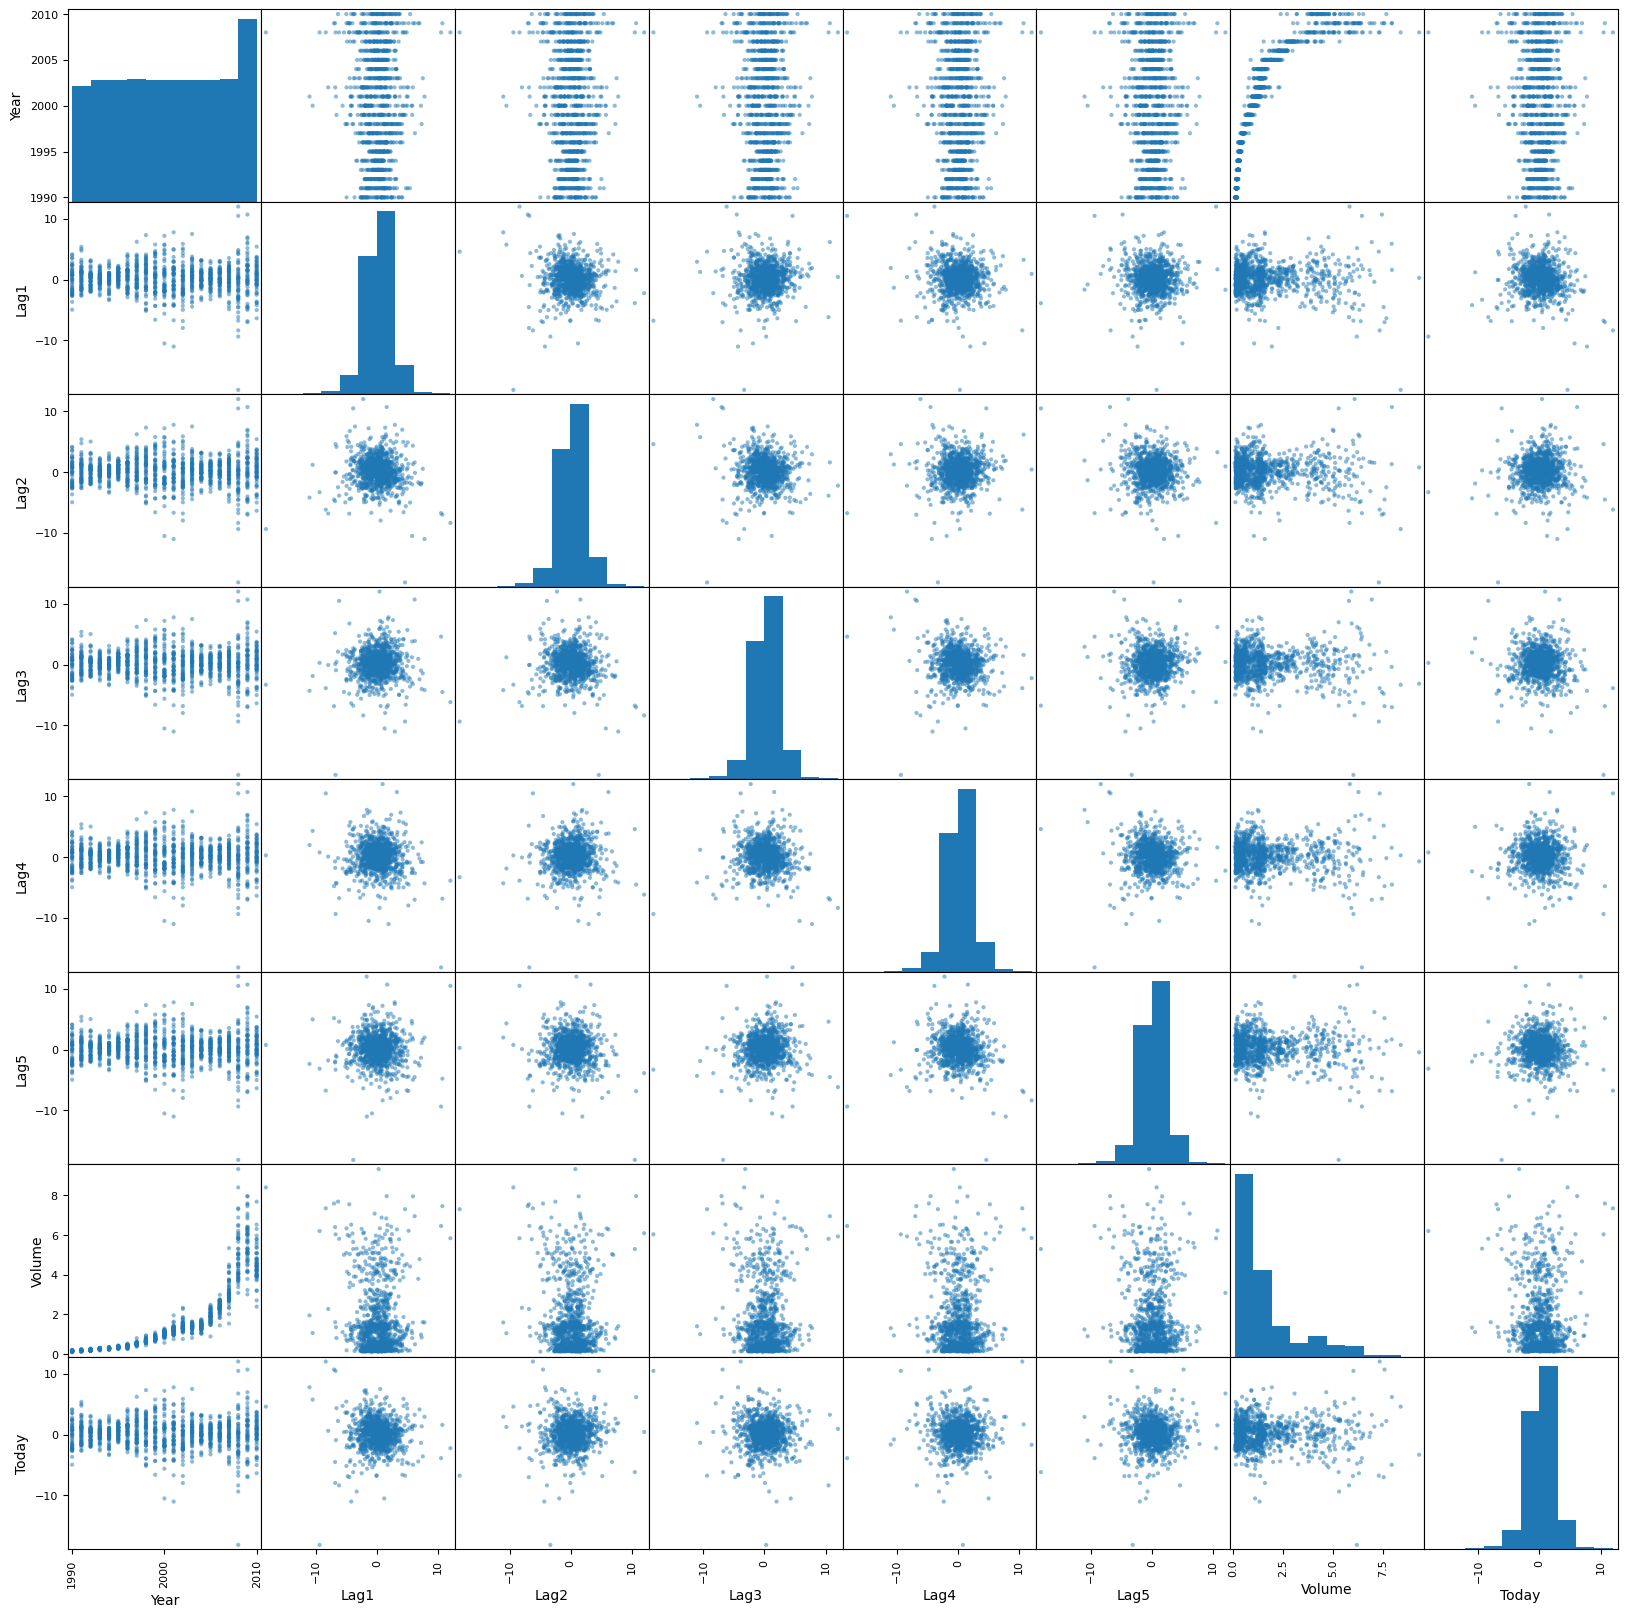

In [6]:
pd.plotting.scatter_matrix(Weekly, figsize=(20,20))
plt.show()

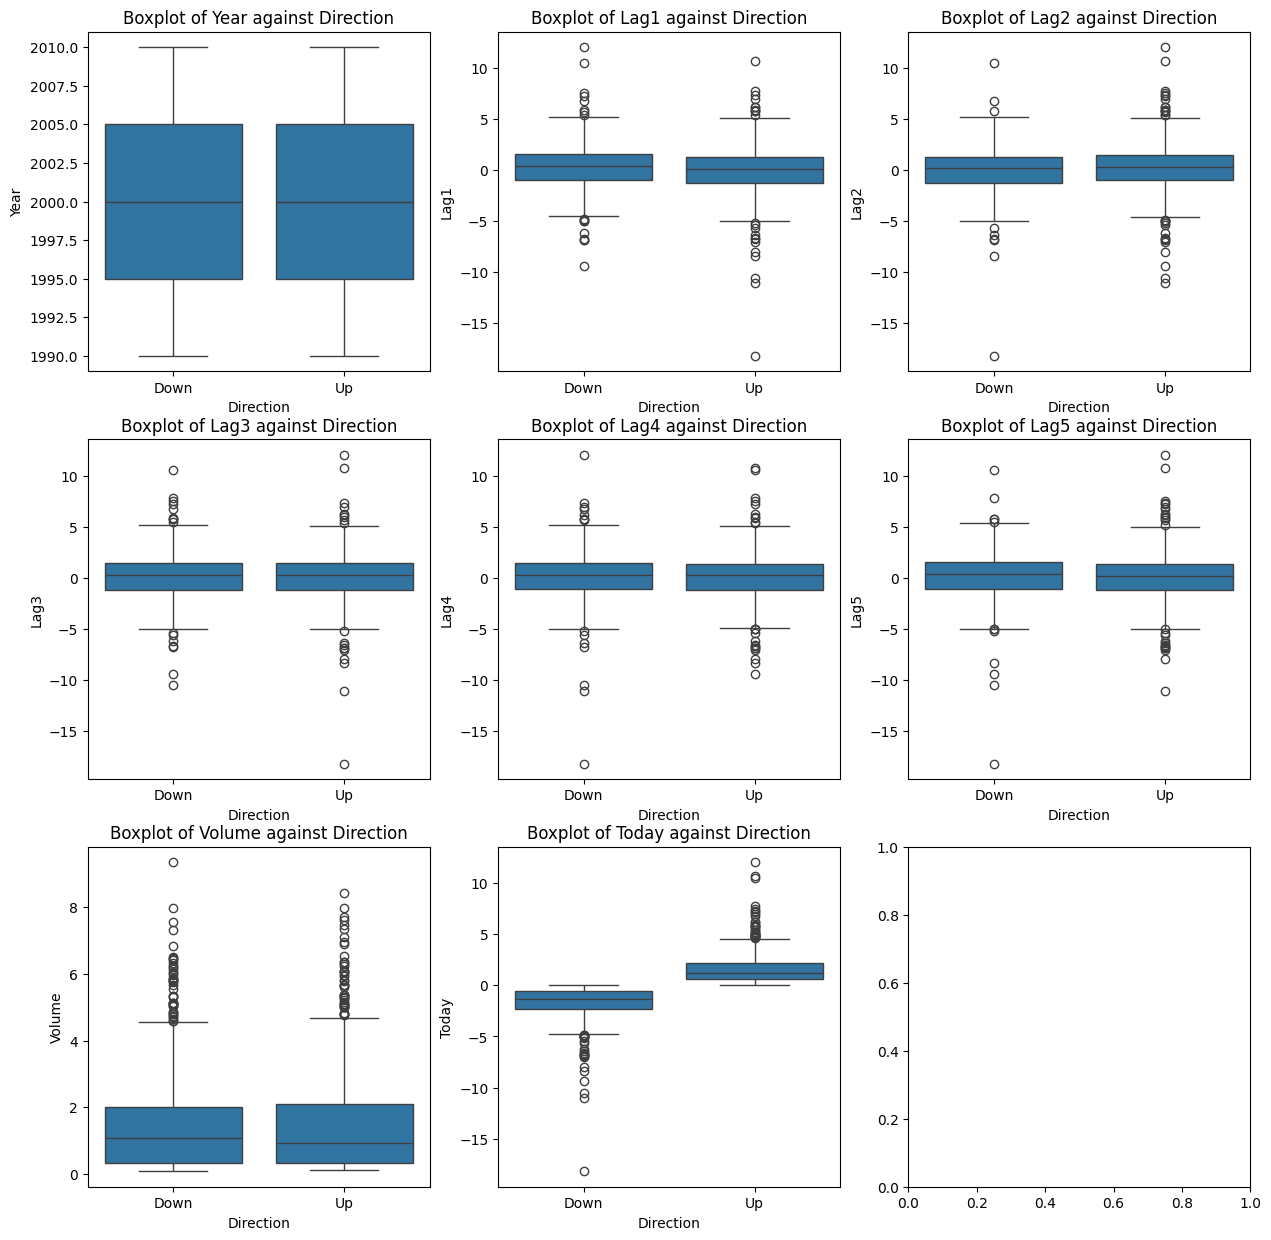

In [7]:
import seaborn as sns
# Plot boxplots
predictors = Weekly.columns.drop("Direction")
num_cols = 3 
num_rows = (len(predictors) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
for i, predictor in enumerate(predictors):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x="Direction", y=predictor, data=Weekly, ax=axes[row][col])
    axes[row][col].set_title(f'Boxplot of {predictor} against Direction')


(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

As we can see, only Lag2 has the p_value less than 0.05 so it appears to be statistically significant. Other variable fail to reject the null hypothesis $\beta=0$

In [8]:
allvars = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(summarize(results))

             coef  std err      z  P>|z|
intercept  0.2669    0.086  3.106  0.002
Lag1      -0.0413    0.026 -1.563  0.118
Lag2       0.0584    0.027  2.175  0.030
Lag3      -0.0161    0.027 -0.602  0.547
Lag4      -0.0278    0.026 -1.050  0.294
Lag5      -0.0145    0.026 -0.549  0.583
Volume    -0.0227    0.037 -0.616  0.538


(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [9]:
probs = results.predict()
labels = np.array(['Down']*probs.shape[0])
labels[probs >0.5] = "Up"
table = confusion_table(labels , Weekly.Direction)
print("Overall fraction of correct predictions: ", (table.iloc[0,0] + table.iloc[1,1])/probs.shape[0])
print(table)

Overall fraction of correct predictions:  0.5610651974288338
Truth      Down   Up
Predicted           
Down         54   48
Up          430  557


Suppose Up is the possitive class, and Down is the negative class.

The confusion matrix's diagonal: indicate accurate predictions, whereas the off-diagonal entries represent incorrect ones. The model accurately forecasted 
- market would go down for 54 days (True Negatives)
- market would go up for 557 (True Possitives) days.

=> Therefore, logistic regression successfully predicted market movements (54 + 557) = 611 days correctly and the overall fraction of correct prediction is 611 / 1089 = 56.1% of the time.

- 48 (False Negatives) is the number of points of "Up" class that the model predicts incorrectly as "Down"
- 54 (Fasle Positives) is the number of points  of "Down" class that the model predicts incorrectly as "Up"


(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

As from the result the overall fraction of correct predictions for the held out data is 46.15%

In [10]:
train = (Weekly.Year <= 2008)
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train]
print("Weekly_train.shape: ", Weekly_train.shape)
print("Weekly_test.shape: ", Weekly_test.shape)

Weekly_train.shape:  (985, 9)
Weekly_test.shape:  (104, 9)


In [11]:
design = MS(['Lag2'])
X = design.fit_transform(Weekly)

X_train , X_test = X.loc[train], X.loc[~train]
y_train , y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train , X_train , family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

D = Weekly.Direction
L_train , L_test = D.loc[train], D.loc[~train]
labels = np.array(['Down'] * Weekly_test.shape[0])
labels[probs >0.5] = 'Up'
print("=== Confusion matrix Linear regression ==== ")
print(confusion_table(labels , L_test))
print("============================= ")
print("- Test accuracy: ", np.mean(labels == L_test))
print("- Error rate: ", np.mean(labels != L_test))

=== Confusion matrix Linear regression ==== 
Truth      Down  Up
Predicted          
Down          9   5
Up           34  56
- Test accuracy:  0.625
- Error rate:  0.375


(e) Repeat (d) using LDA.

In [12]:
X_train , X_test = [M.drop(columns=['intercept']) for M in [X_train , X_test]]

In [13]:
lda = LDA(store_covariance=True)
lda.fit(X_train , L_train)
lda_pred = lda.predict(X_test)
print("=== Confusion matrix LDA ==== ")
print(confusion_table(lda_pred , L_test))
print("============================= ")
print("- Test accuracy: ", np.mean(lda_pred == L_test))
print("- Error rate: ", np.mean(lda_pred != L_test))

=== Confusion matrix LDA ==== 
Truth      Down  Up
Predicted          
Down          9   5
Up           34  56
- Test accuracy:  0.625
- Error rate:  0.375


(f) Repeat (d) using QDA.

In [14]:
qda = QDA(store_covariance=True)
qda.fit(X_train , L_train)
qda_pred = qda.predict(X_test)
print("=== Confusion matrix QDA ==== ")
print(confusion_table(qda_pred , L_test))
print("============================= ")
print("- Test accuracy: ", np.mean(qda_pred == L_test))
print("- Error rate: ", np.mean(qda_pred != L_test))

=== Confusion matrix QDA ==== 
Truth      Down  Up
Predicted          
Down          0   0
Up           43  61
- Test accuracy:  0.5865384615384616
- Error rate:  0.41346153846153844


(g) Repeat (d) using KNN with K = 1.

In [15]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train , L_train)
knn1_pred = knn1.predict(X_test)
print("=== Confusion matrix KNN k = 1 ==== ")
print(confusion_table(knn1_pred , L_test))
print("============================= ")
print("- Test accuracy: ", np.mean(knn1_pred == L_test))
print("- Error rate: ", np.mean(knn1_pred != L_test))

=== Confusion matrix KNN k = 1 ==== 
Truth      Down  Up
Predicted          
Down         21  30
Up           22  31
- Test accuracy:  0.5
- Error rate:  0.5


(h) Repeat (d) using naive Bayes.

In [16]:
NB = GaussianNB()
NB.fit(X_train , L_train)
nb_labels = NB.predict(X_test)
print("=== Confusion matrix naive Bayes ==== ")
print(confusion_table(nb_labels , L_test))
print("============================= ")
print("- Test accuracy: ", np.mean(nb_labels == L_test))
print("- Error rate: ", np.mean(nb_labels != L_test))

=== Confusion matrix naive Bayes ==== 
Truth      Down  Up
Predicted          
Down          0   0
Up           43  61
- Test accuracy:  0.5865384615384616
- Error rate:  0.41346153846153844


(i) Which of these methods appears to provide the best results on this data?

1. **Logistic Regression and LDA:**
   - Both Logistic Regression and LDA perform similarly with a confusion matrix of [[9, 34], [5, 56]] and an overall accuracy of 62.50%.

2. **QDA and GaussianNB:**
   - Both QDA and GaussianNB also have identical confusion matrices [[0, 43], [0, 61]] and overall accuracies of 58.65%.

3. **KNN with K=1:**
   - KNN with k=1 has a lower overall accuracy of 50.00% with a confusion matrix of [[21, 22], [30, 31]].

(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [17]:
def analyze(model_specs):
    methods = {
        'LDA': LDA(store_covariance=True),
        'QDA': QDA(store_covariance=True),
        'Naive bayes': GaussianNB(),
        'KNN K = 1': KNeighborsClassifier(n_neighbors=1),
        'KNN K = 2': KNeighborsClassifier(n_neighbors=2),
        'KNN K = 3': KNeighborsClassifier(n_neighbors=3),
        'KNN K = 4': KNeighborsClassifier(n_neighbors=4),
        'KNN K = 5': KNeighborsClassifier(n_neighbors=5),
    }
    train = (Weekly.Year <= 2008)
    Weekly_test = Weekly.loc[~train]

    design = MS(model_specs)
    X = design.fit_transform(Weekly)
    X_train , X_test = X.loc[train], X.loc[~train]
    y_train , y_test = y.loc[train], y.loc[~train]
    glm_train = sm.GLM(y_train , X_train , family=sm.families.Binomial())
    results = glm_train.fit()
    probs = results.predict(exog=X_test)
    

    D = Weekly.Direction
    L_train , L_test = D.loc[train], D.loc[~train]
    labels = np.array(['Down'] * Weekly_test.shape[0])
    labels[probs >0.5] = 'Up'

    lr_accuracy = np.mean(labels == L_test)
    print('Linear Regression Test Accuracy: ', lr_accuracy)

    X_train , X_test = [M.drop(columns=['intercept']) for M in [X_train , X_test]]

    for name, method in methods.items():
        method.fit(X_train , L_train)
        y_pred = method.predict(X_test)
        print(f"{name} Test Accuracy: ", np.mean(y_pred == L_test))

Using all 5 predictors ''Lag1', 'Lag2', 'Lag3', 'Lag4', 'Today' increase the accuracy compared to only 'Lag2'.
- Linear Regression Test Accuracy can achieve 100% accuracy, followed by NaiveBayes with 99% and LDA with 98.1%.
- As we can observe increase K also help to increase the accuracy.


In [23]:
analyze(model_specs=['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Today'])

Linear Regression Test Accuracy:  1.0
LDA Test Accuracy:  0.9807692307692307
QDA Test Accuracy:  0.9134615384615384
Naive bayes Test Accuracy:  0.9903846153846154
KNN K = 1 Test Accuracy:  0.9134615384615384
KNN K = 2 Test Accuracy:  0.9134615384615384
KNN K = 3 Test Accuracy:  0.9326923076923077
KNN K = 4 Test Accuracy:  0.9230769230769231
KNN K = 5 Test Accuracy:  0.9326923076923077


/Users/haily/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Adding an interaction term 'Lag3' and 'Lag2' can not improve the accuracy, it has the same accuracy for Linear Regression and LDA using only Lag2.

In [19]:
analyze(model_specs=['Lag2', 'Lag3', ('Lag3', 'Lag2')])

Linear Regression Test Accuracy:  0.625
LDA Test Accuracy:  0.625
QDA Test Accuracy:  0.5769230769230769
Naive bayes Test Accuracy:  0.5865384615384616
KNN K = 1 Test Accuracy:  0.46153846153846156
KNN K = 2 Test Accuracy:  0.4230769230769231
KNN K = 3 Test Accuracy:  0.5096153846153846
KNN K = 4 Test Accuracy:  0.49038461538461536
KNN K = 5 Test Accuracy:  0.5288461538461539


Adding an interaction term 'Lag1' and 'Lag2' lower the accuracy to only 57.6% for Linear Regression and LDA.

In [20]:
analyze(model_specs=['Lag2', 'Lag1', ('Lag2', 'Lag1')])

Linear Regression Test Accuracy:  0.5769230769230769
LDA Test Accuracy:  0.5769230769230769
QDA Test Accuracy:  0.46153846153846156
Naive bayes Test Accuracy:  0.47115384615384615
KNN K = 1 Test Accuracy:  0.5192307692307693
KNN K = 2 Test Accuracy:  0.46153846153846156
KNN K = 3 Test Accuracy:  0.49038461538461536
KNN K = 4 Test Accuracy:  0.5288461538461539
KNN K = 5 Test Accuracy:  0.6153846153846154


Using the polynomial of degree 4 of 'Lag2' also lower the performance of the discussed methods and by far results in the worst accuracy

In [21]:
analyze([poly('Lag2', degree=4), 'Volume'])

Linear Regression Test Accuracy:  0.4519230769230769
LDA Test Accuracy:  0.4519230769230769
QDA Test Accuracy:  0.5865384615384616
Naive bayes Test Accuracy:  0.49038461538461536
KNN K = 1 Test Accuracy:  0.47115384615384615
KNN K = 2 Test Accuracy:  0.46153846153846156
KNN K = 3 Test Accuracy:  0.4807692307692308
KNN K = 4 Test Accuracy:  0.4326923076923077
KNN K = 5 Test Accuracy:  0.46153846153846156
